In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from scipy import stats, signal
from loading import load_session_data
from target import build_tgt_matrix, get_spike_counts, build_silence_and_noise_events,\
        get_idxs_of_event_periods, build_silence_matrix, get_spike_times_at
np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions

['009266_hippoSIT_2023-04-13_08-57-46',
 '009266_hippoSIT_2023-04-14_09-17-34',
 '009266_hippoSIT_2023-04-17_09-06-10',
 '009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_09-11-06',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [137]:
session = sessions[-5]
session

'009266_hippoSIT_2023-05-22_09-27-22'

In [138]:
session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
aeps_events = session_data['aeps_events']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
h5_file = session_data['h5_file']
session

'009266_hippoSIT_2023-05-22_09-27-22'

In [139]:
# all silence fake pulses
s_offset, latency = aeps_events[0][0], 0.25
drift = ((aeps_events[:, 0] - s_offset) % latency)[-1]
pulses_silence, pulses_noise = build_silence_and_noise_events(tl, s_offset, latency, drift)

# silence periods
periods = get_idxs_of_event_periods(tl, 0)
pulses_by_period = get_spike_times_at(tl, pulses_silence, periods, mode='sequence')
pulses_times     = np.array([item for sublist in pulses_by_period for item in sublist])  # flatten to one array

# binning
hw, bc = 0.25, 16
bins = np.linspace(0, hw, bc)

ISI_dict = {}
for i, unit_name in enumerate(unit_names):
    spiketrain = get_spike_times_at(tl, spike_times[unit_name], periods, mode='sequence')
    spiketrain = np.array([item for sublist in spiketrain for item in sublist])  # flatten to one array
    
    spk_count_mx = np.zeros([len(pulses_times), bc - 1])
    for j, t_pulse in enumerate(pulses_times):
        #selected = spk_times[(spk_times > t_pulse) & (spk_times < t_pulse + hw)]
        spk_count_mx[j] = np.histogram(spiketrain, bins=bins + t_pulse)[0]
        
    ISI_dict[unit_name] = spk_count_mx

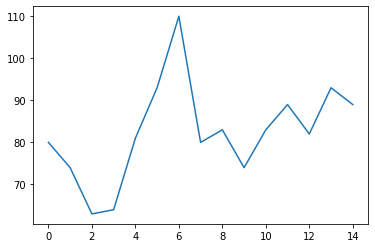

In [148]:
spk_count_mx = ISI_dict['1-31']

plt.plot(spk_count_mx.sum(axis=0))

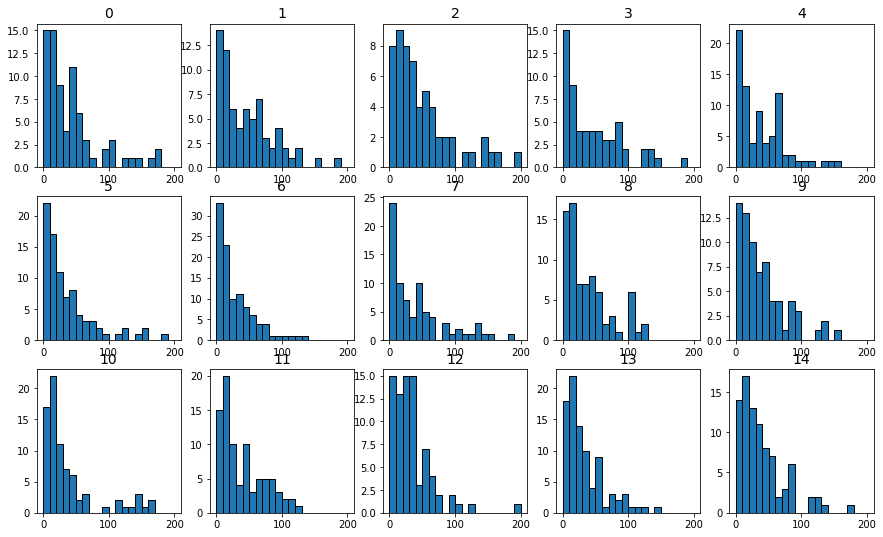

In [151]:
fig = plt.figure(figsize=(15, 9))

bins_diff = np.linspace(0, 200, 21)
for i in range(spk_count_mx.shape[1]):
    ax = fig.add_subplot(3, 5, i+1)
    ax.hist(np.diff(np.where(spk_count_mx[:, i] > 0)[0]), bins=bins_diff, edgecolor='black')
    ax.set_title(str(i), fontsize=14)

In [145]:
def autocorr(spike_times, t_max=0.6):
    ISIs = np.diff(spike_times)
    ISIs = ISIs[ISIs < t_max]
    return np.concatenate([ISIs, -1*ISIs])

In [146]:
unit_name = '1-31'
spiketrain = get_spike_times_at(tl, spike_times[unit_name], periods, mode='sequence')
spiketrain = np.array([item for sublist in spiketrain for item in sublist])  # flatten to one array
spiketrain.sort()

ISIs = autocorr(spiketrain)

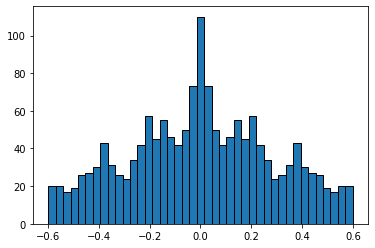

In [147]:
_ = plt.hist(ISIs, bins=41, edgecolor='black')